# Building Your Research Project: Understanding Your City

Now we'll put the pieces together by analyzing data from New York City's 311 service (non-emergency complaints such as noise, streetlights, and potholes). This project follows a typical research workflow.

If this seems big, we'll build it step by step.

## Why This Project Matters

Cities collect data about citizen complaints to understand problems and allocate resources. By analyzing this data, we can answer questions like:

- What bothers people most in NYC?
- Do different neighborhoods have different problems?
- How quickly does the city respond?
- Are there patterns we can learn from?

Urban planners, sociologists, and policy makers use this dataset. The steps here mirror common research practice.

## Project Setup: Creating Your Workspace

We need to organize our files properly. Good organization prevents confusion later.

### Step 1: Create Your Project Folder

Open your terminal or command prompt and type:

```bash
# Navigate to your Desktop (or wherever you want to work)
cd Desktop

# Create a new folder for our project
mkdir nyc_311_project

# Go into that folder
cd nyc_311_project

# Create subfolders to organize our work
mkdir data
mkdir notebooks
mkdir output
```

You've just created this structure:

```
nyc_311_project/
    data/       # Where we'll save data files
    notebooks/  # Where we'll write our analysis
    output/     # Where we'll save results
```

### Fallback: Working Offline

Working offline or on a restricted network? Download the sample 311 dataset, move it into your `nyc_311_project/data/` folder as `311_raw.json`, and use this fallback cell in your notebook to load it if the API is unavailable.

In [2]:
# Fallback: load local sample if network/API is unavailable
import pandas as pd, json, os

local_path = os.path.join('data', '311_raw.json')
df_raw = None

if os.path.exists(local_path):
    try:
        df_raw = pd.read_json(local_path)
    except ValueError:
        # If not JSON-lines, try standard JSON array
        with open(local_path, 'r') as f:
            data = json.load(f)
        df_raw = pd.DataFrame(data)

if df_raw is not None:
    print(f"Loaded {len(df_raw)} rows from local sample")

## Part 1: Understanding the Data (Start Small!)

Before diving into thousands of records, let's understand what we're working with.

In [3]:
# Cell 1: Import what we need
"""
NYC 311 Service Request Analysis
=================================
First, let's explore what New Yorkers complain about.

First, we import the tools we need:
- requests: to get data from the internet
- pandas: to work with data tables
- matplotlib: to make charts
"""

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

print("✓ Tools loaded successfully!")
print(f"Starting analysis at {datetime.now().strftime('%I:%M %p')}")

✓ Tools loaded successfully!
Starting analysis at 11:05 PM


### What is an API endpoint?

The NYC 311 data lives at a web address (URL) called an "endpoint". Think of it like a data vending machine - you send a request, it sends back data.

In [4]:
# Cell 2: Get a tiny sample first
"""
Let's start with just 10 records to understand the data structure.
It's like looking at a sample before buying the whole thing.
"""

# The URL where NYC stores 311 data
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# Ask for just 10 records
params = {
    "$limit": 10  # Only get 10 records for now
}

print("Requesting 10 sample records...")
response = requests.get(url, params=params)

# Check if it worked
if response.status_code == 200:
    print("✓ Retrieved data")

    # Convert the JSON data to a Python list
    sample_data = response.json()

    # How many records did we get?
    print(f"Received {len(sample_data)} records")

    # Look at the first record's structure
    if sample_data:
        first_record = sample_data[0]
        print(f"\nThe data has these fields:")
        for key in list(first_record.keys())[:10]:  # Show first 10 fields
            print(f"  - {key}")
else:
    print(f"❌ Error: {response.status_code}")

Requesting 10 sample records...
✓ Retrieved data
Received 10 records

The data has these fields:
  - unique_key
  - created_date
  - agency
  - agency_name
  - complaint_type
  - descriptor
  - incident_zip
  - incident_address
  - street_name
  - cross_street_1


### Understanding JSON Data

The data comes back as JSON, which Python converts to dictionaries and lists. Let's examine it:

In [5]:
# Cell 3: Explore the data structure
"""
Each record is a dictionary with information about one complaint.
Let's see what a real complaint looks like.
"""

if sample_data:
    # Take the first complaint
    complaint = sample_data[0]

    print("=" * 50)
    print("SAMPLE COMPLAINT DETAILS")
    print("=" * 50)

    # Show the most interesting fields
    important_fields = [
        'complaint_type',    # What kind of complaint
        'descriptor',        # More details
        'borough',          # Which part of NYC
        'created_date',     # When reported
        'status',           # Current status
        'agency'            # Who handles it
    ]

    for field in important_fields:
        if field in complaint:
            value = complaint[field]
            print(f"{field:15} : {value}")

    print("\nLoaded data from NYC Open Data")

SAMPLE COMPLAINT DETAILS
complaint_type  : Street Condition
descriptor      : Pothole
borough         : QUEENS
created_date    : 2025-10-29T01:36:54.000
status          : Open
agency          : DOT

Loaded data from NYC Open Data


## Part 2: Getting More Data (Scaling Up)

Since we understand the structure, let's get more data to analyze:

In [6]:
# Cell 4: Get data from the last week
"""
Let's get serious - fetch all complaints from the last 7 days.
We'll add date filtering to get recent data.
"""

def fetch_recent_complaints(days_back=7, limit=1000):
    """
    Get recent 311 complaints from NYC.

    Parameters:
    -----------
    days_back : int
        How many days of history to get
    limit : int
        Maximum number of records to fetch

    Returns:
    --------
    list : List of complaint records
    """

    print(f"Fetching complaints from the last {days_back} days...")

    # Calculate the date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)

    # Format dates for the API (YYYY-MM-DDTHH:MM:SS)
    start_str = start_date.strftime('%Y-%m-%dT00:00:00')
    end_str = end_date.strftime('%Y-%m-%dT23:59:59')

    # Build the query
    params = {
        '$limit': limit,
        '$where': f"created_date between '{start_str}' and '{end_str}'"
    }

    # Make the request
    try:
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            print(f"✓ Retrieved {len(data)} complaints")
            return data
        else:
            print(f"❌ Error: {response.status_code}")
            return []

    except Exception as e:
        print(f"❌ Something went wrong: {e}")
        return []

# Get the data
complaints = fetch_recent_complaints(days_back=7, limit=1000)

Fetching complaints from the last 7 days...
✓ Retrieved 1000 complaints


### Converting to a DataFrame

Pandas DataFrames are like Excel sheets in Python. They make data analysis much easier:

In [1]:
# Cell 5: Convert to DataFrame
"""
A DataFrame is like a smart spreadsheet.
It can sort, filter, and calculate things automatically.
"""

# Convert our list of complaints to a DataFrame
df = pd.DataFrame(complaints)

# How big is our dataset?
print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

# Show the first few rows (like preview in Excel)
print("\nFirst 5 complaints:")
df.head()

NameError: name 'pd' is not defined

## Part 3: Cleaning the Data

Real data is messy. Let's clean it up:

In [ ]:
# Cell 6: Basic data cleaning
"""
Data cleaning is like organizing a messy desk:
- Remove duplicates
- Fix formats
- Handle missing values
"""

print("BEFORE CLEANING")
print(f"Total records: {len(df)}")
print(f"Columns: {df.shape[1]}")

# Keep only the columns we care about
columns_to_keep = [
    'unique_key',         # Unique ID for each complaint
    'created_date',       # When reported
    'closed_date',        # When resolved (if resolved)
    'agency',             # Which agency handles it
    'complaint_type',     # Type of complaint
    'descriptor',         # More details
    'borough',            # Location
    'status'              # Current status
]

# Some columns might not exist, so let's check
columns_that_exist = []
for col in columns_to_keep:
    if col in df.columns:
        columns_that_exist.append(col)
df_clean = df[columns_that_exist].copy()

print(f"\nAFTER SELECTING COLUMNS")
print(f"Columns kept: {len(df_clean.columns)}")

# Convert date strings to actual dates
if 'created_date' in df_clean.columns:
    df_clean['created_date'] = pd.to_datetime(df_clean['created_date'])
    print("✓ Converted created_date to datetime format")

if 'closed_date' in df_clean.columns:
    df_clean['closed_date'] = pd.to_datetime(df_clean['closed_date'])
    print("✓ Converted closed_date to datetime format")

# Remove duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset='unique_key', keep='first')
after = len(df_clean)
print(f"✓ Removed {before - after} duplicate records")

print(f"\nCLEAN DATASET")
print(f"Final shape: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

BEFORE CLEANING
Total records: 1000
Columns: 40

AFTER SELECTING COLUMNS
Columns kept: 8
✓ Converted created_date to datetime format
✓ Converted closed_date to datetime format
✓ Removed 0 duplicate records

CLEAN DATASET
Final shape: 1000 rows, 8 columns


## Part 4: Basic Analysis (What Can We Learn?)

Next, let's look for patterns in the data.

TOP 10 COMPLAINT TYPES
 1. HEAT/HOT WATER: 222
 2. Illegal Parking: 209
 3. Noise - Residential: 142
 4. Noise - Street/Sidewalk: 51
 5. Blocked Driveway: 41
 6. Noise: 33
 7. Noise - Commercial: 30
 8. Street Condition: 28
 9. UNSANITARY CONDITION: 22
10. Noise - Vehicle: 19


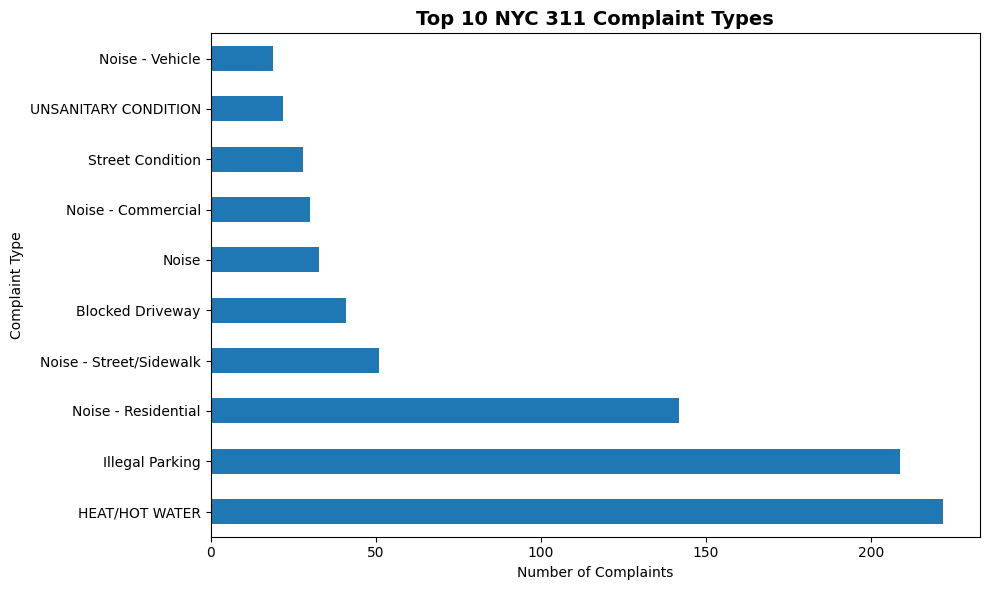

In [ ]:
# Cell 7: Most common complaints
"""
What do New Yorkers complain about most?
Let's count complaint types and visualize them.
"""

# Count each complaint type
complaint_counts = df_clean['complaint_type'].value_counts()

# Show top 10 (simple listing)
print("TOP 10 COMPLAINT TYPES")
for i, (complaint, count) in enumerate(complaint_counts.head(10).items(), 1):
    print(f"{i:2}. {complaint}: {count}")

# Now make a proper chart
plt.figure(figsize=(10, 6))
complaint_counts.head(10).plot(kind='barh')  # Horizontal bar chart
plt.title('Top 10 NYC 311 Complaint Types', fontsize=14, fontweight='bold')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.tight_layout()
plt.show()

COMPLAINTS BY BOROUGH
BROOKLYN         289 (28.9%)
MANHATTAN        240 (24.0%)
BRONX            232 (23.2%)
QUEENS           213 (21.3%)
STATEN ISLAND     25 (2.5%)


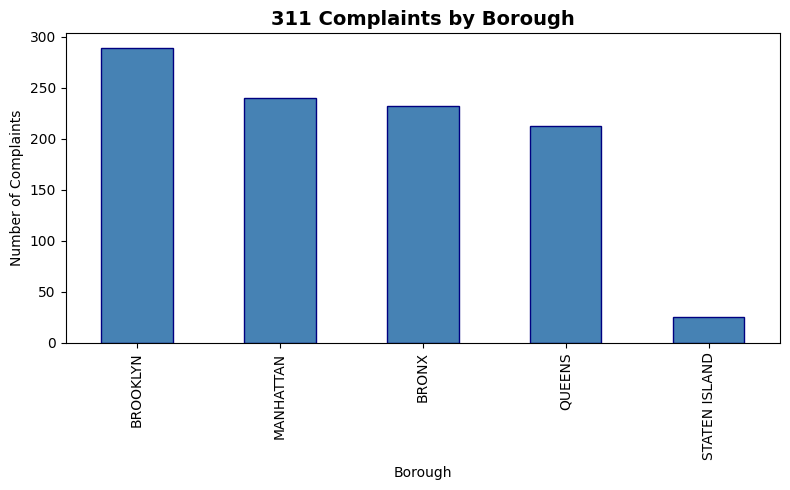

In [ ]:
# Cell 8: Complaints by borough
"""
Do different parts of NYC have different problems?
Let's see how complaints vary by borough.
"""

if 'borough' in df_clean.columns:
    # Count by borough
    borough_counts = df_clean['borough'].value_counts()

    # Remove 'Unspecified' if it exists
    if 'Unspecified' in borough_counts.index:
        borough_counts = borough_counts.drop('Unspecified')

    print("COMPLAINTS BY BOROUGH")
    print("=" * 40)

    total = borough_counts.sum()
    for borough, count in borough_counts.items():
        percentage = (count / total) * 100
        print(f"{borough:15} {count:4} ({percentage:.1f}%)")

    # Visualize (bar chart for clarity)
    plt.figure(figsize=(8, 5))
    borough_counts.plot(kind='bar', color='steelblue', edgecolor='navy')
    plt.title('311 Complaints by Borough', fontsize=14, fontweight='bold')
    plt.xlabel('Borough')
    plt.ylabel('Number of Complaints')
    plt.tight_layout()
    plt.show()
else:
    print("Borough information not available in this dataset")

In [ ]:
# Cell 9: Response times
"""
How quickly does NYC respond to complaints?
Let's calculate the time from report to resolution.
"""

if 'closed_date' in df_clean.columns:
    # Filter for closed complaints only
    closed = df_clean[df_clean['closed_date'].notna()].copy()

    if len(closed) > 0:
        # Calculate response time in hours
        closed['response_hours'] = (
            closed['closed_date'] - closed['created_date']
        ).dt.total_seconds() / 3600

        # Remove negative times (data errors)
        closed = closed[closed['response_hours'] > 0]

        # Basic statistics
        print("RESPONSE TIME STATISTICS")
        print("=" * 40)
        print(f"Average: {closed['response_hours'].mean():.1f} hours")
        print(f"Median: {closed['response_hours'].median():.1f} hours")
        print(f"Fastest: {closed['response_hours'].min():.1f} hours")
        print(f"Slowest: {closed['response_hours'].max():.1f} hours")

        # Which complaints get resolved fastest?
        print("\nFASTEST RESOLVED COMPLAINT TYPES")
        print("=" * 40)

        # Group by complaint type and calculate median response time
        response_by_type = closed.groupby('complaint_type')['response_hours'].agg([
            'count',   # How many
            'median'   # Typical response time
        ])

        # Only include types with at least 5 complaints
        response_by_type = response_by_type[response_by_type['count'] >= 5]

        # Sort by median response time
        response_by_type = response_by_type.sort_values('median')

        # Show top 5 fastest
        for complaint_type, row in response_by_type.head(5).iterrows():
            print(f"{complaint_type:30} {row['median']:.1f} hours")
    else:
        print("No closed complaints found in this dataset")
else:
    print("Closed date information not available")

RESPONSE TIME STATISTICS
Average: 14.5 hours
Median: 3.6 hours
Fastest: 0.0 hours
Slowest: 140.9 hours

FASTEST RESOLVED COMPLAINT TYPES
Vendor Enforcement             0.3 hours
Encampment                     0.7 hours
Noise - Vehicle                0.7 hours
Noise - Commercial             0.7 hours
Noise - Street/Sidewalk        0.8 hours


## Part 5: Time Patterns

When do people complain most?

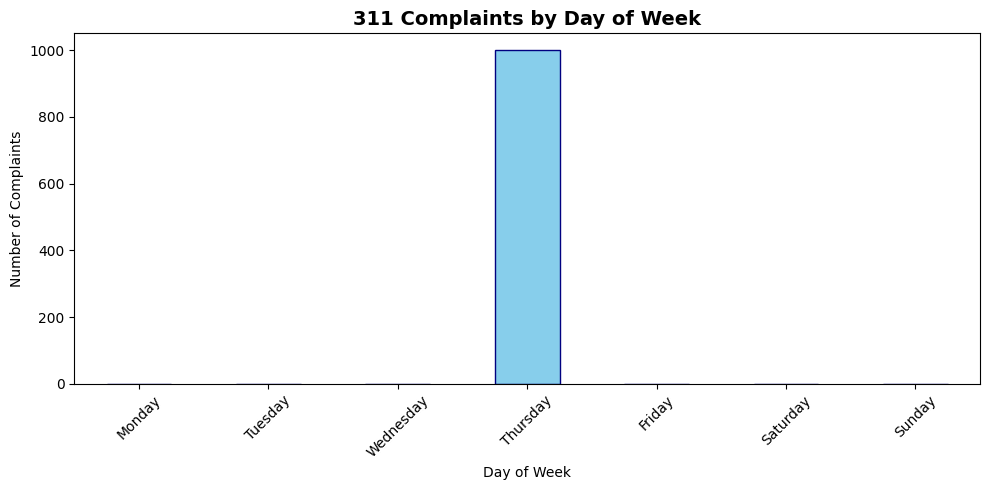

Busiest day: Thursday (1000.0 complaints)
Quietest day: Thursday (1000.0 complaints)


In [ ]:
# Cell 10: Complaints by day of week
"""
Are there more complaints on certain days?
Maybe weekends are different from weekdays?
"""

# Extract day of week from created_date
df_clean['day_of_week'] = df_clean['created_date'].dt.day_name()
df_clean['hour'] = df_clean['created_date'].dt.hour

# Count by day
day_counts = df_clean['day_of_week'].value_counts()

# Put days in order (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)

# Visualize
plt.figure(figsize=(10, 5))
day_counts.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('311 Complaints by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Any patterns?
busiest_day = day_counts.idxmax()
quietest_day = day_counts.idxmin()
print(f"Busiest day: {busiest_day} ({day_counts[busiest_day]} complaints)")
print(f"Quietest day: {quietest_day} ({day_counts[quietest_day]} complaints)")

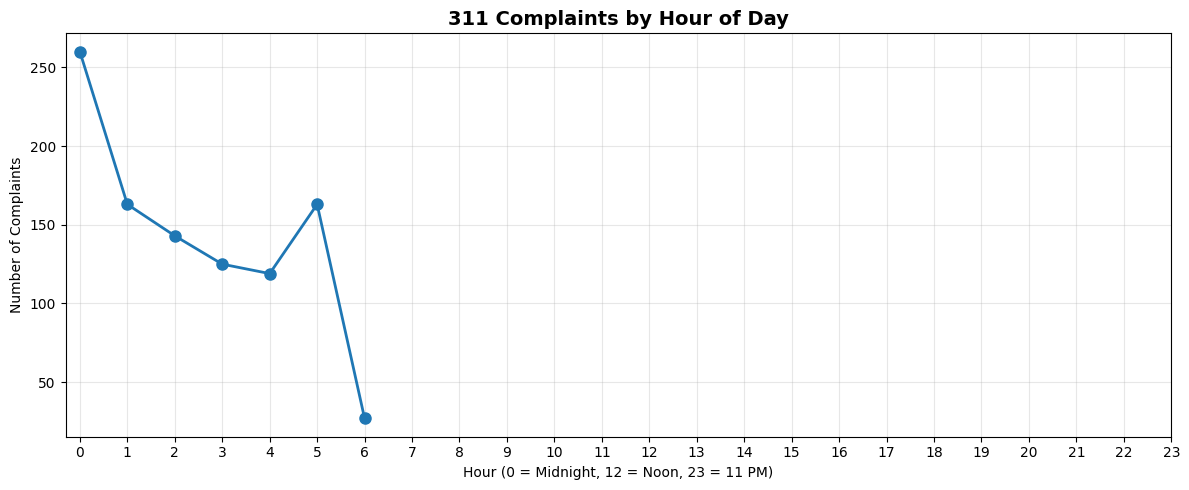

Peak complaint hour: 0:00 (260 complaints)
Quietest hour: 6:00 (27 complaints)


In [ ]:
# Cell 11: Complaints by hour
"""
What time of day do people call 311?
This tells us about daily life patterns in NYC.
"""

hour_counts = df_clean['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
hour_counts.plot(kind='line', marker='o', linewidth=2, markersize=8)
plt.title('311 Complaints by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour (0 = Midnight, 12 = Noon, 23 = 11 PM)')
plt.ylabel('Number of Complaints')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

peak_hour = hour_counts.idxmax()
quiet_hour = hour_counts.idxmin()
print(f"Peak complaint hour: {peak_hour}:00 ({hour_counts[peak_hour]} complaints)")
print(f"Quietest hour: {quiet_hour}:00 ({hour_counts[quiet_hour]} complaints)")

## Part 6: Creating Your Research Report

Let's create a professional summary of our findings:

In [ ]:
# Cell 12: Generate a summary report
"""
A good research report summarizes findings clearly.
Let's create one automatically!
"""

def generate_report(df, filename="311_analysis_report.txt"):
    """
    Generate a text report of our analysis.

    Parameters:
    -----------
    df : DataFrame
        The cleaned 311 data
    filename : str
        Where to save the report
    """

    # Prepare the report content
    report_lines = []
    report_lines.append("=" * 60)
    report_lines.append("NYC 311 SERVICE REQUEST ANALYSIS")
    report_lines.append("=" * 60)
    report_lines.append("")
    report_lines.append(f"Report Generated: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}")
    report_lines.append(f"Analysis Period: {df['created_date'].min()} to {df['created_date'].max()}")
    report_lines.append(f"Total Complaints Analyzed: {len(df):,}")
    report_lines.append("")

    report_lines.append("KEY FINDINGS")
    report_lines.append("-" * 40)

    # Top complaints
    report_lines.append("\n1. Most Common Complaints:")
    for i, (complaint, count) in enumerate(df['complaint_type'].value_counts().head(5).items(), 1):
        percentage = (count / len(df)) * 100
        report_lines.append(f"   {i}. {complaint}: {count} ({percentage:.1f}%)")

    # By borough
    if 'borough' in df.columns:
        report_lines.append("\n2. Complaints by Borough:")
        borough_counts = df['borough'].value_counts()
        for borough, count in borough_counts.head().items():
            if borough != 'Unspecified':
                percentage = (count / len(df)) * 100
                report_lines.append(f"   - {borough}: {count} ({percentage:.1f}%)")

    # Time patterns
    report_lines.append("\n3. Temporal Patterns:")
    busiest_day = df['day_of_week'].value_counts().idxmax()
    peak_hour = df['hour'].value_counts().idxmax()
    report_lines.append(f"   - Busiest Day: {busiest_day}")
    report_lines.append(f"   - Peak Hour: {peak_hour}:00")

    # Response times (if available)
    if 'closed_date' in df.columns:
        closed = df[df['closed_date'].notna()]
        if len(closed) > 0:
            response_times = (closed['closed_date'] - closed['created_date']).dt.total_seconds() / 3600
            response_times = response_times[response_times > 0]  # Remove negative values

            report_lines.append("\n4. Response Times:")
            report_lines.append(f"   - Average: {response_times.mean():.1f} hours")
            report_lines.append(f"   - Median: {response_times.median():.1f} hours")

    report_lines.append("")
    report_lines.append("=" * 60)
    report_lines.append("END OF REPORT")

    # Join all lines
    report_text = "\n".join(report_lines)

    # Display the report
    print(report_text)

    # Save to file
    with open(filename, 'w') as f:
        f.write(report_text)

    print(f"\n✓ Report saved to {filename}")

    return report_text

# Generate our report
report = generate_report(df_clean)

NYC 311 SERVICE REQUEST ANALYSIS

Report Generated: October 30, 2025 at 09:20 PM
Analysis Period: 2025-10-23 00:00:00 to 2025-10-23 06:06:27
Total Complaints Analyzed: 1,000

KEY FINDINGS
----------------------------------------

1. Most Common Complaints:
   1. HEAT/HOT WATER: 222 (22.2%)
   2. Illegal Parking: 209 (20.9%)
   3. Noise - Residential: 142 (14.2%)
   4. Noise - Street/Sidewalk: 51 (5.1%)
   5. Blocked Driveway: 41 (4.1%)

2. Complaints by Borough:
   - BROOKLYN: 289 (28.9%)
   - MANHATTAN: 240 (24.0%)
   - BRONX: 232 (23.2%)
   - QUEENS: 213 (21.3%)
   - STATEN ISLAND: 25 (2.5%)

3. Temporal Patterns:
   - Busiest Day: Thursday
   - Peak Hour: 0:00

4. Response Times:
   - Average: 14.5 hours
   - Median: 3.6 hours

END OF REPORT

✓ Report saved to 311_analysis_report.txt


## Part 7: Saving Your Work

Let's save our cleaned data and visualizations:

✓ Saved cleaned data to cleaned_311_data.csv
✓ Saved visualization to 311_analysis_summary.png


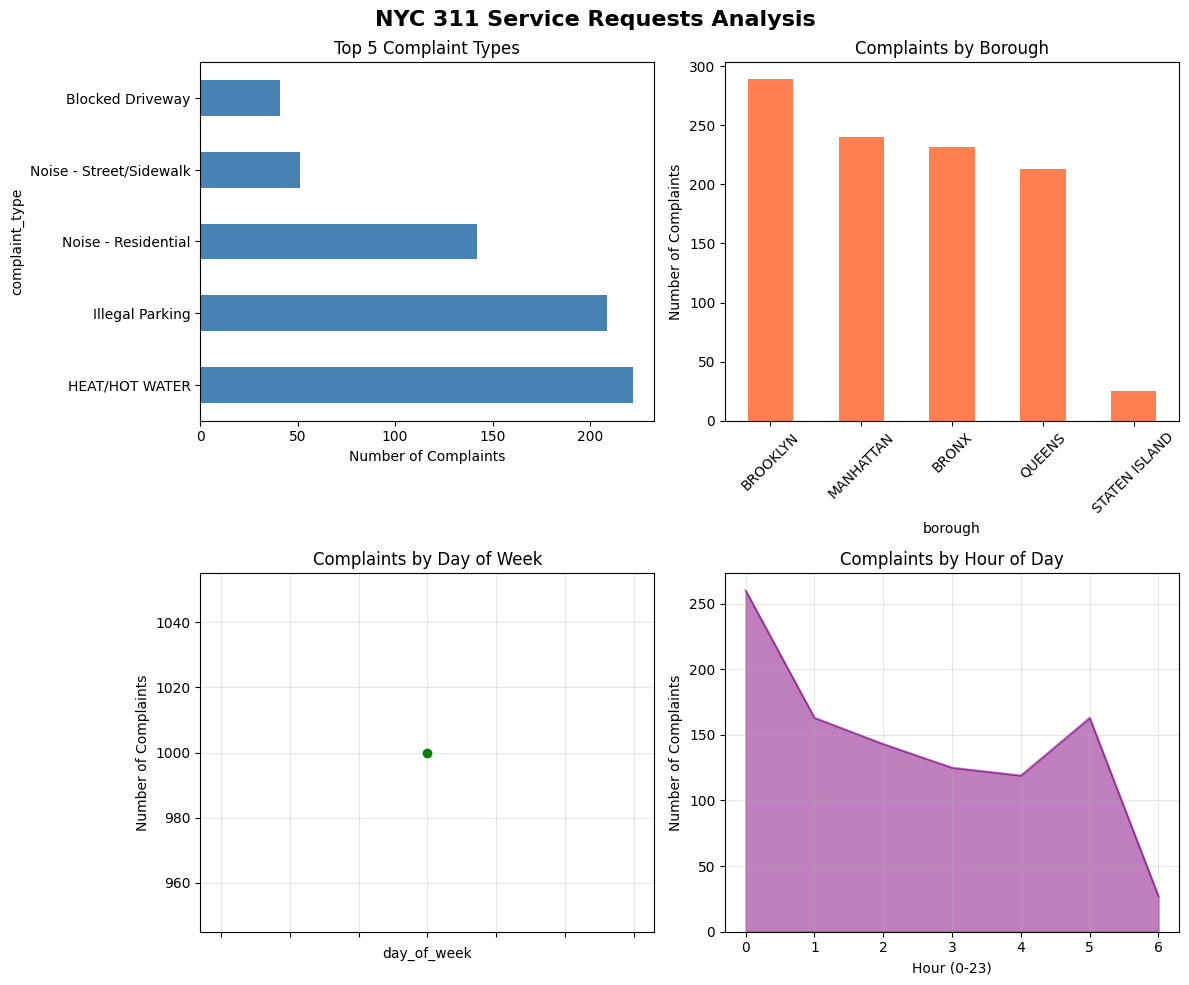

In [ ]:
# Cell 13: Save everything
"""
Save your work as you go.
Let's save our data and create a summary visualization.
"""

# Save the cleaned data
output_file = "cleaned_311_data.csv"
df_clean.to_csv(output_file, index=False)
print(f"✓ Saved cleaned data to {output_file}")

# Create a summary visualization with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Top complaint types
ax1 = axes[0, 0]
df_clean['complaint_type'].value_counts().head(5).plot(
    kind='barh', ax=ax1, color='steelblue'
)
ax1.set_title('Top 5 Complaint Types')
ax1.set_xlabel('Number of Complaints')

# 2. By borough
ax2 = axes[0, 1]
if 'borough' in df_clean.columns:
    borough_data = df_clean['borough'].value_counts()
    if 'Unspecified' in borough_data.index:
        borough_data = borough_data.drop('Unspecified')
    borough_data.plot(kind='bar', ax=ax2, color='coral')
    ax2.set_title('Complaints by Borough')
    ax2.set_ylabel('Number of Complaints')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# 3. By day of week
ax3 = axes[1, 0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_data = df_clean['day_of_week'].value_counts().reindex(day_order)
day_data.plot(kind='line', ax=ax3, marker='o', color='green')
ax3.set_title('Complaints by Day of Week')
ax3.set_ylabel('Number of Complaints')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.grid(True, alpha=0.3)

# 4. By hour
ax4 = axes[1, 1]
hour_data = df_clean['hour'].value_counts().sort_index()
hour_data.plot(kind='area', ax=ax4, color='purple', alpha=0.5)
ax4.set_title('Complaints by Hour of Day')
ax4.set_xlabel('Hour (0-23)')
ax4.set_ylabel('Number of Complaints')
ax4.grid(True, alpha=0.3)

plt.suptitle('NYC 311 Service Requests Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('311_analysis_summary.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to 311_analysis_summary.png")

plt.show()

## Wrap-Up: Analysis Complete

You just:

1. Collected real data from NYC's API
2. Cleaned messy real-world data
3. Analyzed patterns and trends
4. Visualized your findings
5. Reported your results professionally

These are common steps in data analysis.

## What You Learned

Through this project, you've practiced:

- **API requests**: Getting data from the internet
- **Data cleaning**: Handling messy, real-world data
- **Pandas**: Working with DataFrames
- **Data analysis**: Finding patterns and insights
- **Visualization**: Creating clear, informative charts
- **Documentation**: Writing clear explanations

## Next Steps: Make It Your Own

Now try modifying the analysis:

- **Different time period**: Change `days_back` to 30 for a month of data
- **Different borough**: Filter for just Manhattan or Brooklyn
- **Specific complaints**: Focus on noise complaints or heating issues
- **New questions**: What agencies handle the most complaints? Are there seasonal patterns?

### Example modification:

Found 278 noise-related complaints


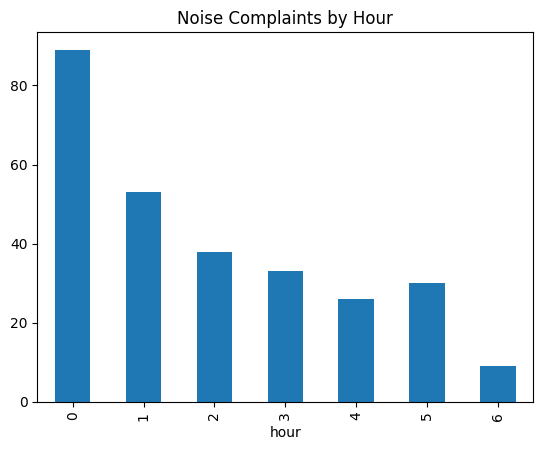

In [ ]:
# Focus on just noise complaints
noise_df = df_clean[df_clean['complaint_type'].str.contains('Noise', case=False, na=False)]
print(f"Found {len(noise_df)} noise-related complaints")

# When do noise complaints happen?
noise_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Noise Complaints by Hour')
plt.show()

## Troubleshooting Common Issues

### "No data returned"
- Check your internet connection
- The API might be temporarily down (try again in a few minutes)
- You might have a typo in the URL

### "KeyError" when accessing columns
- That column might not exist in your data
- Use `df.columns` to see what columns are available
- Some datasets might have different column names

### Charts look weird
- Make sure you have data to plot
- Check for NaN (missing) values
- Try a different chart type

### Memory errors with large datasets
- Reduce the `limit` parameter
- Work with fewer days of data
- Close other programs to free up memory

**Note**: Real data is often messy. Handling these issues is part of the learning process.

## Key Takeaways

1. **Start small**: Test with a few records before processing thousands
2. **Check your data**: Always look at what you actually received
3. **Clean carefully**: Real data has missing values, duplicates, and errors
4. **Visualize to understand**: Charts reveal patterns that numbers hide
5. **Document everything**: Your future self will thank you

You can apply these techniques to other datasets.